<a href="https://colab.research.google.com/github/EmeryBosten/Nanaqua_workshop/blob/main/NANAQUA_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Automated Method Development and Signal Processing in Liquid Chromatography**

In [ ]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
# Load libraries
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import math
from skopt import gp_minimize
from skopt import plots
import scipy.sparse as sparse
from scipy.sparse.linalg import splu

In [ ]:
# Utility functions
def nk_isocratic_model(parameters, phi):

    """Neue-kuss isocratic retention model.
    Parameters
    ----------
    parameters: list
        The Neue-Kuss parameters (S1, S2, kw)
    phi: np.ndarray or float
        The fraction of strong eluent.
    Returns
    -------
    k: np.ndarray
        Retention factors modelled via params and phi
    """

    s1, s2, kw = parameters

    return kw * (1 + s2 * phi)**2 * np.exp(-(s1 * phi) / (1 + s2 * phi))

def nk_gradient_model(
    params, phi_start, phi_end, gradient_duration,
    dwell_time=0.614, void_time=0.5):

    """Neue-Kuss gradient retention model, which takes into account elution
    before gradient (`k_before_gradient`), during gradient (`k_during_gradient`),
    and after gradient (`k_after_gradient`).
    Parameters
    ----------
    params: tuple
        The Neue-Kuss parameters (S1, S2, kw)
    phi_start: np.ndarray or float
        The fraction of strong eluent (`phi`) at the start of the gradient
    phi_end: np.ndarray or float
        The fraction of strong eluent (`phi`) at the end of the gradient
    gradient_duration: np.ndarray or float
        The duration of the gradient (from `phi_start` to `phi_end`). The unit
        is in minutes (so e.g. `5.5` would be 5.5 min)
    dwell_time: float
        The dwell time of the system (time delay for the gradient). Usually
        a constant value.
    void_time: float
        The void time of the system (the time it takes for an unretained
        molecule to make it from the injection to the detector). Usually
        a constant value.
    Returns
    -------
    retention_time: np.ndarray
        Retention times modelled via parameters
    """

    epsilon = 1e-7

    S1, S2, kw = params

    beta = (phi_end - phi_start) / gradient_duration

    k_start = nk_isocratic_model([S1, S2, kw], phi_start)
    k_end = nk_isocratic_model([S1, S2, kw], phi_end)

    # Elution before start of gradient
    k_before_gradient = k_start

    # Elution during the gradient
    phi_elution_numerator = (
        phi_start + (1 + S2 * phi_start) / S1 * np.log(
            1 + S1 * beta * kw *
            np.exp(-(S1 * phi_start) / (1 + S2 * phi_start)) *
            (void_time - dwell_time / k_start)
        )
    )
    phi_elution_denominator = (
        1 - (S2 * (1 + S2 * phi_start)) / S1 * np.log(
            1 + S1 * beta * kw *
            np.exp(-(S1 * phi_start) / (1 + S2 * phi_start)) *
            (void_time - dwell_time / k_start)
        )
    )
    phi_elution = phi_elution_numerator / phi_elution_denominator

    k_during_gradient = (
        dwell_time/void_time + (phi_elution - phi_start) / (beta*void_time))

    # Elution after the gradient
    k_after_gradient = (
        k_end - k_end / k_start * dwell_time / void_time +
        dwell_time / void_time +
        gradient_duration / void_time -
        k_end / (beta * void_time * kw * S1) * (
            np.exp((S1 * phi_end) / (1 + S2 * phi_end)) -
            np.exp((S1 * phi_start) / (1 + S2 * phi_start))
        )
    )

    condition_1 = np.logical_or(
        np.logical_and(
            (void_time) < (k_start * void_time + void_time),
            (k_start * void_time + void_time) < (void_time + dwell_time)),
        np.logical_or(
            (np.abs(phi_end - phi_start) < epsilon),
            (gradient_duration < epsilon)))

    condition_2 = np.logical_and(
        (void_time + dwell_time) < (k_start * void_time + void_time),
        (k_during_gradient * void_time + void_time) < (void_time + dwell_time + gradient_duration))

    k = np.where(
        condition_1,
        k_before_gradient,
        np.where(
            condition_2,
            k_during_gradient,
            k_after_gradient
        )
    )

    tr = k * void_time + void_time # retention time
    phi_at_elution = np.where(
        tr <= (void_time + dwell_time),
        phi_start,
        np.where(
            tr > (void_time + dwell_time + gradient_duration),
            phi_end,
            phi_elution
        )
    )
    return k, phi_at_elution,tr

# function to generate NK parameters (kw, S1, S2)
def obtain_compound(nb_cmps, seed):
    np.random.seed(seed)

    S2 = np.random.uniform(0.9, 1.8, nb_cmps)

    S1 = S2 * 33.8898 - 18.1336

    logkw = S2 * 10.9507 - 6.2011
    kw = np.exp(logkw)

    return S1, S2, kw

#factors to determine peak widths

def getb(t0, phi_start,phi_end, gradient_duration,S):
  return  (t0*(phi_end-phi_start)*S)/gradient_duration

def getp(t0, phi_start,phi_end, gradient_duration,S):
  b = getb(t0, phi_start,phi_end, gradient_duration,S)
  return 2.3*b

def getG(t0, phi_start,phi_end, gradient_duration,S):
    p = getp(t0, phi_start,phi_end, gradient_duration,S)
    return np.sqrt(1 + p + ((p**2)/3))/(1+p)

#correction factor of peak compression
def getJ(t0, phi_start,phi_end, gradient_duration,S):
    b = getb(t0, phi_start,phi_end, gradient_duration,S)
    #return 0.99 + 1.70*b - 1.35*(b**2) + 0.48*(b**3) - 0.062*(b**4)
    return 1

#transfrom rt to k
def getk(rt,t0):
    return (rt-t0)/t0

#get peak width
def getscale(N,t0,rt,phi_start, phi_end,gradient_duration,S):
    G = getG(t0, phi_start,phi_end, gradient_duration,S)
    J = getJ(t0, phi_start,phi_end, gradient_duration,S)
    return 4*G*J*(t0*(getk(rt,t0)+1))/np.sqrt(N)

# peak pair resolution
def res(rt1, rt2, w1, w2):
    return 2*abs(rt2-rt1)/ (4*(w1+w2))

#transform k to rt
def k_to_tr(k, t0):
    return k*t0 + t0

#objective function
def getObj(rt,s,k,t0):
    arr = np.array([np.array(rt), np.array(k), np.array(s)]).transpose()
    sorted_by_col = arr[arr[:, 0].argsort()]
    rs = []
    for i in range(1, len(rt)):
            r = res(sorted_by_col[i-1,0],sorted_by_col[i,0], sorted_by_col[i-1,2], sorted_by_col[i,2])
            rs.append(r)
    critres = min(rs)
    if critres > 2 : critres = 2

    rt_min = k_to_tr(2, t0)
    k = sorted_by_col[:,1]

    if k[-1] > 20 and k[0] > 2: Obj = critres**2/math.sqrt(sorted_by_col[-1,0])
    elif k[-1] > 20 and k[0] < 2: Obj = (critres**2)*(sorted_by_col[0,0]/rt_min)/math.sqrt(sorted_by_col[-1,0])
    elif k[-1] < 20 and k[0] < 2 : Obj = (critres**2)*(sorted_by_col[0,0]/rt_min)
    else : Obj = critres**2


    return Obj, critres

#functions to generate simulated chromatogram
#peak shape
def compute_gaussian_peak(x, A, loc, scale, asymmetry=None, eps=1e-7):
    if asymmetry is None:
        return A * np.exp((-(x - loc)**2) / (2 * scale**2))
    return A * np.exp(-1/2*((x - loc)/(eps + scale + asymmetry * (x - loc)))**2)

#noise
def apply_white_noise(x, A, snr, random_seed):
    '''
    Random sampling from a normal distribution to generate white noise.
    '''
    np.random.seed(random_seed)
    stddev = A.mean() / snr / 4 # approximately noise levels that match snr
    noise = np.random.normal(0, stddev, len(x))
    return x + noise

#simulator class
class Simulator:

    def __init__(self,
                 time,
                 resolution,
                 num_peaks,
                 snr_range,
                 A_range,
                 loc,
                 scale,
                 asymmetry_range,
                 ):

        self.time = time
        self.resolution = resolution
        self.x = np.linspace(0, time, resolution)
        self.num_peaks = num_peaks
        self.snr_range = snr_range
        self.A_range = A_range
        self.loc = loc
        self.scale = scale
        self.asymmetry_range = asymmetry_range


    def run(self, random_seed):

        np.random.seed(random_seed)

        # Randomly obtain parameters of the peaks
        self.A = np.random.uniform(*self.A_range, size=(self.num_peaks,))

        # Obtain asymmetry if not None (i.e. peak fronting/tailing)
        if self.asymmetry_range is not None:
            self.asymmetry = np.random.uniform(*self.asymmetry_range, size=(self.num_peaks,))
        else:
            self.asymmetry = [None] * self.num_peaks

        # Generate (noise-free) chromatogram
        chromatogram = np.zeros_like(self.x)
        for a, m, s, t in zip(self.A, self.loc, self.scale, self.asymmetry):
            chromatogram += compute_gaussian_peak(self.x, a, m, s, t)

        # Obtain random signal-to-noise ratio (SNR)
        self.snr = np.random.uniform(*self.snr_range)
        chromatogram_noisy = apply_white_noise(
                chromatogram, self.A, self.snr, random_seed)

        return (
            chromatogram,
            chromatogram_noisy,
            self.loc,
            self.scale,
            self.A,
            self.x
        )


In [ ]:
# Generate initial chromatogram
# Parameters
nb_cmps = 7 # number of compounds to generate [IS FIXED]
seed = 6 #[IS FIXED]
parameters = obtain_compound(nb_cmps,seed) # generate compound NK parameters
t0 = 0.8 # void time CONSTANT [FIXED]
phi_start = 0.05 # initial phi CONSTANT [FIXED]

#np.random.seed(nb_cmps)
#N = np.random.uniform(10000, 50000, size= nb_cmps) # sample theoretical plate number
N = [13052.33157496, 41196.7516896,  27536.36925764, 38938.60711324, 49119.58047986, 31539.83481642, 30044.8185464] # sample theoretical plate number


## PUT PARAMETERS TO TUNE HERE
phi_end = 0.95 # end phi TUNE
gradient_duration = 5 # gradient time TUNE

# Initial conditions for optimization
x0 = np.array([phi_end, gradient_duration])



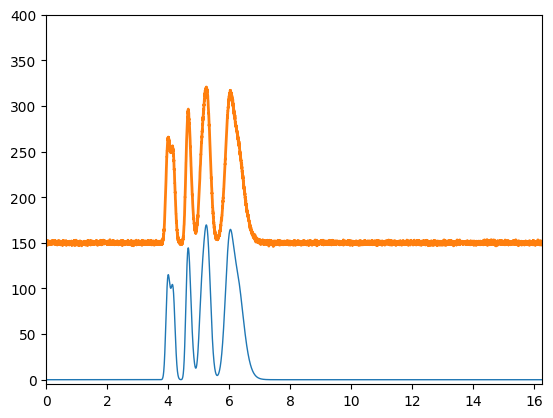

0.16483092653164622


In [ ]:
# Plot initial chromatogram
[k, phi_at_elution, rt] = nk_gradient_model( parameters, phi_start, phi_end, gradient_duration, dwell_time=0.614, void_time=t0)
s = getscale(N,t0,rt,phi_start, phi_end,gradient_duration,1)

#initiate simulator
simulator = Simulator(
    time=gradient_duration+max(rt)+5, #add t min for highly retained peaks
    resolution=8192,
    num_peaks=nb_cmps,
    snr_range=(25.0, 45.0),
    A_range=(5, 200),
    loc=rt,
    scale=s,
    asymmetry_range=(-0.1, 0.1)  # Include asymmetry
)

# generate chromatograms

# initialize lists
chroms = []
chroms_noisy = []
# set number of chromatograms to generate
n_chroms = 1

# generate chromsatograms with simulator
for i in range(n_chroms):

    c, c_noisy, p_loc, p_scale, p_A, p_x = simulator.run(i)
    chroms.append(c)
    chroms_noisy.append(c_noisy)


# plot chromatogram
fig, ax = plt.subplots()

ax.plot(p_x, chroms[0], linewidth=1.0)
ax.plot(p_x, chroms_noisy[0] + 150, linewidth=2.0)

ax.set(xlim=(0, gradient_duration+max(rt)+5),
       ylim=(-5, 400))

plt.show()

# Value of objective function
print(getObj(rt, s, k, t0)[0])

In [ ]:
# Sequential Simplex Algorithm for Method Development
#starting conditions
phi_end = 0.5 # end phi TUNE
gradient_duration = 10 # gradient time TUNE
x0 = np.array([phi_end, gradient_duration])

#Addtional fixed parameters for objective function
myargs = (parameters, phi_start)

# function to optimize
def opt_objective(x, *myargs):
  parameters = myargs[0]
  phi_start = myargs[1]
  phi_end = x[0]
  gradient_duration = x[1]
  [k, phi_at_elution, rt] = nk_gradient_model(
  parameters, phi_start, phi_end, gradient_duration,
  dwell_time=0.614, void_time=t0)
  s = getscale(N,t0,rt,phi_start, phi_end,gradient_duration,1)
  Obj = (1)/(getObj(rt, s, k, t0)[0])
  return Obj

#SSM algorithm
result = minimize(opt_objective, x0, args=myargs, method='nelder-mead', bounds = ((0.25, 1), (0.95, 30)),
               options={'maxiter' : 500,'xatol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: 2.446769
         Iterations: 37
         Function evaluations: 71


In [ ]:
#Print optimal conditions
print(result.x)

[ 0.3542406  13.58097398]


In [ ]:
#Bayesian Optimization for Method Development

## PUT PARAMETERS TO TUNE HERE
phi_end = 0.5 # end phi TUNE
gradient_duration = 10 # gradient time TUNE

# function to optimize
def opt_objective(x,):
  phi_end = x[0]
  gradient_duration = x[1]
  [k, phi_at_elution, rt] = nk_gradient_model(
  parameters, phi_start, phi_end, gradient_duration,
  dwell_time=0.614, void_time=t0)
  s = getscale(N,t0,rt,phi_start, phi_end,gradient_duration,1)
  Obj = (1)/(getObj(rt, s, k, t0)[0])
  return Obj

# BO algorithm
result = gp_minimize(opt_objective,       # the function to minimize
                  [(0.25, 0.95), (1, 30)], # the bounds on each dimension of x
                  acq_func="EI",          # the acquisition function
                  n_calls=50,             # the number of evaluations of f
                  n_random_starts=5,      # the number of random initialization points
                  noise=0.1**2,           # the noise level (optional)
                  random_state=1234)      # the random seed

In [ ]:
# print optimal conditions
print(result.x)

[0.5858656119687947, np.int64(5)]


In [ ]:
# print value of objective function
print(result.fun)

1.7020371152073839


<Axes: >

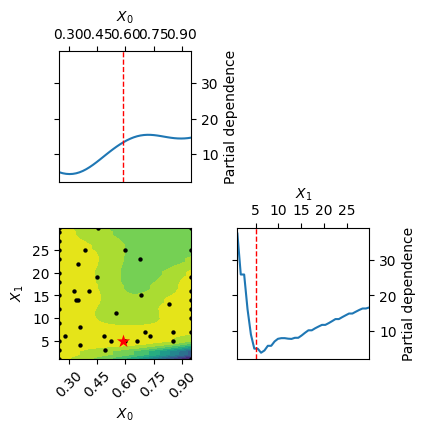

In [ ]:
plots.plot_objective(result)

In [ ]:
# Noise removal

def speyediff(N, d, format='csc'):
    """
    (utility function)
    Construct a d-th order sparse difference matrix based on
    an initial N x N identity matrix

    Final matrix (N-d) x N
    """

    assert not (d < 0), "d must be non negative"
    shape     = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format=format)
    return spmat


def whittaker_smooth(y, lmbd, d = 2):
    """
    Implementation of the Whittaker smoothing algorithm,
    based on the work by Eilers [1].

    [1] P. H. C. Eilers, "A perfect smoother", Anal. Chem. 2003, (75), 3631-3636

    The larger 'lmbd', the smoother the data.
    For smoothing of a complete data series, sampled at equal intervals

    This implementation uses sparse matrices enabling high-speed processing
    of large input vectors

    ---------

    Arguments :

    y       : vector containing raw data
    lmbd    : parameter for the smoothing algorithm (roughness penalty)
    d       : order of the smoothing

    ---------

    Returns :

    z       : vector of the smoothed data.
    """

    m = len(y)
    E = sparse.eye(m, format='csc')
    D = speyediff(m, d, format='csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z


Text(0.5, 1.0, 'Noisy chrom smoothed with d = 3 and lambda = 10, 10**6, 10**9, 10**12')

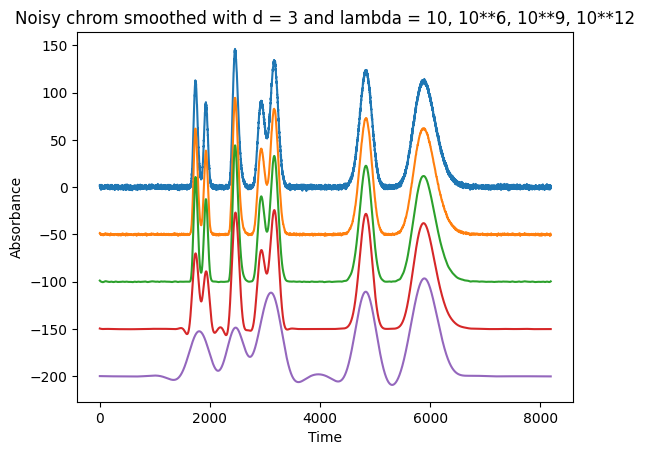

In [ ]:
# Hyperparameter d
d = 3
# Noise removal using WS
c_sm10 = whittaker_smooth(c_noisy, 10, d)
c_sm10_6 = whittaker_smooth(c_noisy, 10**6, d)
c_sm10_9 = whittaker_smooth(c_noisy, 10**9, d)
c_sm10_12 = whittaker_smooth(c_noisy, 10**12, d)
#plot
plt.figure(1)
plt.clf()
plt.plot(c_noisy)
plt.plot(c_sm10-50)
plt.plot(c_sm10_6-100)
plt.plot(c_sm10_9-150)
plt.plot(c_sm10_12-200)
plt.xlabel('Time')
plt.ylabel('Absorbance')
plt.title('Noisy chrom smoothed with d = 3 and lambda = 10, 10**6, 10**9, 10**12')
#plt.ylim(-60,60)
#plt.xlim(0,1100)

Text(0.5, 1.0, 'Peak Detection')

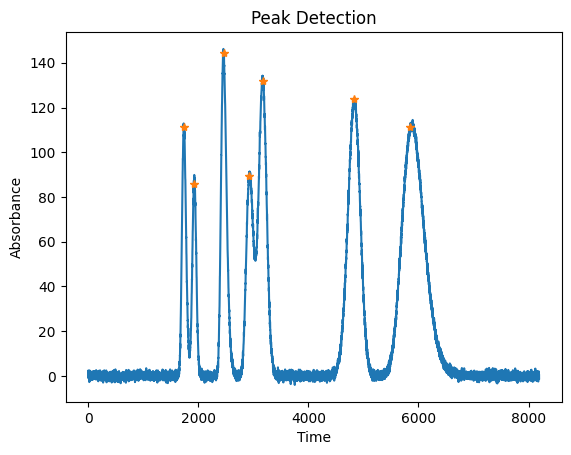

In [ ]:
# Peak detection

def findMin(deriv2, y, noise_thresh, height_ratio, minimum_depth):
    """
    Function to find peak apex based on minima in second derivative
    Translated from MATLAB to Python (NumPy)

    Parameters
    ----------
    deriv2 : array_like
        Second derivative of the signal
    y : array_like
        Original signal
    noise_thresh : float
        Noise threshold multiplier
    height_ratio : float
        Height ratio constraint
    minimum_depth : float
        Minimum depth factor for derivative minima

    Returns
    -------
    apex_loc : np.ndarray
        Indices of detected minima
    """

    deriv2 = np.asarray(deriv2, dtype=float)
    y = np.asarray(y, dtype=float)

    # normalization (between -1 and 1)
    max_deriv2 = np.max(np.abs(deriv2))
    deriv2 = deriv2 / max_deriv2

    k = 1.4826
    max_y_noise = k * np.median(np.abs(y[:100] - np.median(y[:100])))
    max_y = np.max(y)  # highest peak in original signal
    max_deriv2_noise = k * np.median(np.abs(deriv2[:100] - np.median(deriv2[:100])))

    apex_loc = []

    for i in range(3, len(deriv2) - 3):
        cond1 = (deriv2[i-1] > deriv2[i] and deriv2[i-2] > deriv2[i] and deriv2[i-3] > deriv2[i] and
                 deriv2[i+1] > deriv2[i] and deriv2[i+2] > deriv2[i] and deriv2[i+3] > deriv2[i])

        cond2 = deriv2[i] < min(-minimum_depth * max_deriv2_noise,
                                np.min(deriv2) / height_ratio)

        cond3 = y[i] > max(noise_thresh * max_y_noise, max_y / height_ratio)

        if cond1 and cond2 and cond3:
            idx = i
            for j in range(1, 11):
                if (y[idx+j] > y[idx+j+1]) and (y[idx+j] > y[idx+j-1]):
                    idx += j
                if (y[idx-j] > y[idx-j+1]) and (y[idx-j] > y[idx-j-1]):
                    idx -= j
            apex_loc.append(idx)

    return np.unique(apex_loc)

dz2 = np.diff(c_sm10_9, 2);

# locate peaks
apex_loc = findMin(dz2,c_sm10_9,10,15,1);

plt.figure(1)
plt.clf()
plt.plot(c_noisy)
plt.plot(apex_loc,c_noisy[apex_loc], marker = '*', linestyle='None')
plt.xlabel('Time')
plt.ylabel('Absorbance')
plt.title('Peak Detection')